# 2.5 DeepLIFT

## Tensorflow Walkthrough

### 1. Import Dependencies

In [1]:
import os
import re

from tensorflow.examples.tutorials.mnist import input_data
from tensorflow.python.ops import nn_ops, gen_nn_ops
import matplotlib.pyplot as plt
import tensorflow as tf
import numpy as np

from models.models_2_5 import MNIST_CNN
from utils import pixel_range

%matplotlib inline

mnist = input_data.read_data_sets("MNIST_data/", one_hot=True)
images = mnist.train.images
labels = mnist.train.labels

logdir = './tf_logs/2_5_DL/'
ckptdir = logdir + 'model'

if not os.path.exists(logdir):
    os.mkdir(logdir)

Extracting MNIST_data/train-images-idx3-ubyte.gz
Extracting MNIST_data/train-labels-idx1-ubyte.gz
Extracting MNIST_data/t10k-images-idx3-ubyte.gz
Extracting MNIST_data/t10k-labels-idx1-ubyte.gz


### 2. Building Graph

In [2]:
with tf.name_scope('Classifier'):

    # Initialize neural network
    DNN = MNIST_CNN('CNN')

    # Setup training process
    X = tf.placeholder(tf.float32, [None, 784], name='X')
    Y = tf.placeholder(tf.float32, [None, 10], name='Y')
    training = tf.placeholder(tf.bool, name='training')
    activations = DNN(X, training)
    
    X_ref = tf.placeholder(tf.float32, [None, 784], name='X_ref')
    activations_ref = DNN(X_ref, training, reuse=True)
    
    tf.add_to_collection('DL', training)
    tf.add_to_collection('DL', X)
    tf.add_to_collection('DL_ref', X_ref)
    
    for activation in activations:
        tf.add_to_collection('DL', activation)
    
    for activation in activations_ref:
        tf.add_to_collection('DL_ref', activation)

    cost = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(logits=activations[-1], labels=Y))

    optimizer = tf.train.AdamOptimizer().minimize(cost, var_list=DNN.vars)

    correct_prediction = tf.equal(tf.argmax(activations[-1], 1), tf.argmax(Y, 1))
    accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))

cost_summary = tf.summary.scalar('Cost', cost)
accuray_summary = tf.summary.scalar('Accuracy', accuracy)
summary = tf.summary.merge_all()

### 3. Training Network

This is the step where the DNN is trained to classify the 10 digits of the MNIST images. Summaries are written into the logdir and you can visualize the statistics using tensorboard by typing this command: `tensorboard --lodir=./tf_logs`

In [3]:
sess = tf.InteractiveSession()
sess.run(tf.global_variables_initializer())

saver = tf.train.Saver()
file_writer = tf.summary.FileWriter(logdir, tf.get_default_graph())

# Hyper parameters
training_epochs = 15
batch_size = 100

for epoch in range(training_epochs):
    total_batch = int(mnist.train.num_examples / batch_size)
    avg_cost = 0
    avg_acc = 0
    
    for i in range(total_batch):
        batch_xs, batch_ys = mnist.train.next_batch(batch_size)
        _, c, a, summary_str = sess.run([optimizer, cost, accuracy, summary], feed_dict={X: batch_xs, Y: batch_ys, training: True})
        avg_cost += c / total_batch
        avg_acc += a / total_batch
        
        file_writer.add_summary(summary_str, epoch * total_batch + i)

    print('Epoch:', '%04d' % (epoch + 1), 'cost =', '{:.9f}'.format(avg_cost), 'accuracy =', '{:.9f}'.format(avg_acc))
    
    saver.save(sess, ckptdir)

print('Accuracy:', sess.run(accuracy, feed_dict={X: mnist.test.images, Y: mnist.test.labels, training: False}))

sess.close()

Epoch: 0001 cost = 0.297054920 accuracy = 0.908781820
Epoch: 0002 cost = 0.111595800 accuracy = 0.967036371
Epoch: 0003 cost = 0.081733512 accuracy = 0.975145464
Epoch: 0004 cost = 0.067652444 accuracy = 0.979690920
Epoch: 0005 cost = 0.059420204 accuracy = 0.982072738
Epoch: 0006 cost = 0.052106735 accuracy = 0.983563647
Epoch: 0007 cost = 0.045873785 accuracy = 0.986454556
Epoch: 0008 cost = 0.041894900 accuracy = 0.987490919
Epoch: 0009 cost = 0.038917441 accuracy = 0.987454555
Epoch: 0010 cost = 0.034085965 accuracy = 0.989127282
Epoch: 0011 cost = 0.033599649 accuracy = 0.989200009
Epoch: 0012 cost = 0.028438996 accuracy = 0.990472735
Epoch: 0013 cost = 0.028430790 accuracy = 0.990963644
Epoch: 0014 cost = 0.029002894 accuracy = 0.990527281
Epoch: 0015 cost = 0.024741071 accuracy = 0.991709099
Accuracy: 0.9911


### 4. Restoring Subgraph

Here we first rebuild the DNN graph from metagraph, restore DNN parameters from the checkpoint and then gather the necessary weight and biases for Deep Taylor Decomposition using the `tf.get_collection()` function.

In [4]:
tf.reset_default_graph()

sess = tf.InteractiveSession()

new_saver = tf.train.import_meta_graph(ckptdir + '.meta')
new_saver.restore(sess, tf.train.latest_checkpoint(logdir))

weights = tf.get_collection(tf.GraphKeys.TRAINABLE_VARIABLES, scope='.*kernel.*')
activations = tf.get_collection('DL')
activations_ref = tf.get_collection('DL_ref')

training = activations.pop(0)
X = activations.pop(0)
X_ref = activations_ref.pop(0)

INFO:tensorflow:Restoring parameters from ./tf_logs/2_5_DL/model


### 5. Relevance Score Propagation

### Calculating $\Delta$

In [5]:
delta = [activations[i] - activations_ref[i] for i in range(len(activations))]

### Propagation from Output to 3rd Layer Activations: Linear Rule

In [6]:
M = []
C = []

ind = tf.placeholder(tf.int32, [], 'index')

D_4 = delta[7][:,ind,None]
M_4_4 = tf.ones_like(D_4, dtype=tf.float32)
C_4_4 = D_4 * M_4_4

M.append(M_4_4)
C.append(C_4_4)

W_T = tf.transpose(weights[3][:,ind,None])
W_T_p = tf.maximum(W_T, 0.)
W_T_n = tf.minimum(W_T, 0.)

D_3a = delta[6]
D_3a_p = tf.where(0. < D_3a, tf.ones_like(D_3a, dtype=tf.float32), tf.zeros_like(D_3a, dtype=tf.float32))
D_3a_n = tf.where(0. > D_3a, tf.ones_like(D_3a, dtype=tf.float32), tf.zeros_like(D_3a, dtype=tf.float32))
D_3a_z = tf.where(tf.equal(0., D_3a), tf.ones_like(D_3a, dtype=tf.float32), tf.zeros_like(D_3a, dtype=tf.float32))

M_3a_4 = tf.matmul(M_4_4, W_T_p) * D_3a_p + tf.matmul(M_4_4, W_T_n) * D_3a_n + \
         tf.matmul(M_4_4, W_T_p) * D_3a_n + tf.matmul(M_4_4, W_T_n) * D_3a_p + \
         tf.matmul(0.5 * (M_4_4 + M_4_4), W_T) * D_3a_z

C_3a_4 = D_3a * M_3a_4

M.append(M_3a_4)
C.append(C_3a_4)

### Propagation from 3rd Layer Activations to 3rd Layer Pre-Activations: Rescale Rule

In [7]:
D_3a = delta[6]
D_3p = delta[5]

M_3p_3a = tf.where(tf.equal(0., D_3p), tf.gradients(activations[6], activations[5])[0], D_3a / D_3p)
M_3p_4 = M_3p_3a * M_3a_4

C_3p_4 = D_3p * M_3p_4

M.append(M_3p_4)
C.append(C_3p_4)

### Propagation from 3rd Layer Pre-Activations to 2nd Layer Activations: Linear Rule

In [8]:
W_T = tf.transpose(weights[2])
W_T_p = tf.maximum(W_T, 0.)
W_T_n = tf.minimum(W_T, 0.)

D_2a = tf.reshape(delta[4], [-1, 7 * 7 * 64])
D_2a_p = tf.where(0. < D_2a, tf.ones_like(D_2a, dtype=tf.float32), tf.zeros_like(D_2a, dtype=tf.float32))
D_2a_n = tf.where(0. > D_2a, tf.ones_like(D_2a, dtype=tf.float32), tf.zeros_like(D_2a, dtype=tf.float32))
D_2a_z = tf.where(tf.equal(0., D_2a), tf.ones_like(D_2a, dtype=tf.float32), tf.zeros_like(D_2a, dtype=tf.float32))

M_2a_4 = tf.matmul(M_3p_4, W_T_p) * D_2a_p + tf.matmul(M_3p_4, W_T_n) * D_2a_n + \
         tf.matmul(M_3p_4, W_T_p) * D_2a_n + tf.matmul(M_3p_4, W_T_n) * D_2a_p + \
         tf.matmul(M_3p_4, W_T) * D_2a_z

C_2a_4 = D_2a * M_2a_4

M.append(M_2a_4)
C.append(C_2a_4)

### Propagation from 2nd Layer Activations to 2nd Layer Pre-Activations: Rescale Rule

In [9]:
D_2a = delta[4]
D_2p = delta[3]

M_2p_2a = tf.where(tf.equal(0., D_2p), tf.gradients(activations[4], activations[3])[0], D_2a / D_2p)
M_2p_4 = M_2p_2a * tf.reshape(M_2a_4, [-1, 7, 7, 64])

C_2p_4 = D_2p * M_2p_4

M.append(M_2p_4)
C.append(C_2p_4)

### Propagation from 2nd Layer Pre-Activations to 1st Layer Activations: Linear Rule

In [10]:
W = weights[1]
W_p = tf.maximum(W, 0.)
W_n = tf.minimum(W, 0.)

D_1a = delta[2]
D_1a_p = tf.where(0. < D_1a, tf.ones_like(D_1a, dtype=tf.float32), tf.zeros_like(D_1a, dtype=tf.float32))
D_1a_n = tf.where(0. > D_1a, tf.ones_like(D_1a, dtype=tf.float32), tf.zeros_like(D_1a, dtype=tf.float32))
D_1a_z = tf.where(tf.equal(0., D_1a), tf.ones_like(D_1a, dtype=tf.float32), tf.zeros_like(D_1a, dtype=tf.float32))

M_1a_4 = tf.nn.conv2d_transpose(M_2p_4, W_p, tf.shape(D_1a), [1,2,2,1]) * D_1a_p + \
         tf.nn.conv2d_transpose(M_2p_4, W_n, tf.shape(D_1a), [1,2,2,1]) * D_1a_n + \
         tf.nn.conv2d_transpose(M_2p_4, W_p, tf.shape(D_1a), [1,2,2,1]) * D_1a_n + \
         tf.nn.conv2d_transpose(M_2p_4, W_n, tf.shape(D_1a), [1,2,2,1]) * D_1a_p + \
         tf.nn.conv2d_transpose(M_2p_4, W, tf.shape(D_1a), [1,2,2,1]) * D_1a_z

C_1a_4 = D_1a * M_1a_4

M.append(M_1a_4)
C.append(C_1a_4)

### Propagation from 1st Layer Activations to 1st Layer Pre-Activations: Rescale Rule

In [11]:
D_1a = delta[2]
D_1p = delta[1]

M_1p_1a = tf.where(tf.equal(0., D_1p), tf.gradients(activations[2], activations[1])[0], D_1a / D_1p)
M_1p_4 = M_1p_1a * M_1a_4

C_1p_4 = D_1p * M_1p_4

M.append(M_1p_4)
C.append(C_1p_4)

### Propagation from 1st Layer Pre-Activations to Image: Linear Rule

In [12]:
W = weights[0]
W_p = tf.maximum(W, 0.)
W_n = tf.minimum(W, 0.)

D_0 = delta[0]
D_0_p = tf.where(0. < D_0, tf.ones_like(D_0, dtype=tf.float32), tf.zeros_like(D_0, dtype=tf.float32))
D_0_n = tf.where(0. > D_0, tf.ones_like(D_0, dtype=tf.float32), tf.zeros_like(D_0, dtype=tf.float32))
D_0_z = tf.where(tf.equal(0., D_0), tf.ones_like(D_0, dtype=tf.float32), tf.zeros_like(D_0, dtype=tf.float32))

M_0_4 = tf.nn.conv2d_transpose(M_1p_4, W_p, tf.shape(D_0), [1,2,2,1]) * D_0_p + \
         tf.nn.conv2d_transpose(M_1p_4, W_n, tf.shape(D_0), [1,2,2,1]) * D_0_n + \
         tf.nn.conv2d_transpose(M_1p_4, W_p, tf.shape(D_0), [1,2,2,1]) * D_0_n + \
         tf.nn.conv2d_transpose(M_1p_4, W_n, tf.shape(D_0), [1,2,2,1]) * D_0_p + \
         tf.nn.conv2d_transpose(M_1p_4, W, tf.shape(D_0), [1,2,2,1]) * D_0_z

C_0_4 = D_0 * M_0_4

M.append(M_0_4)
C.append(C_0_4)

### 6. Calculating Relevance Scores $R(x_i)$

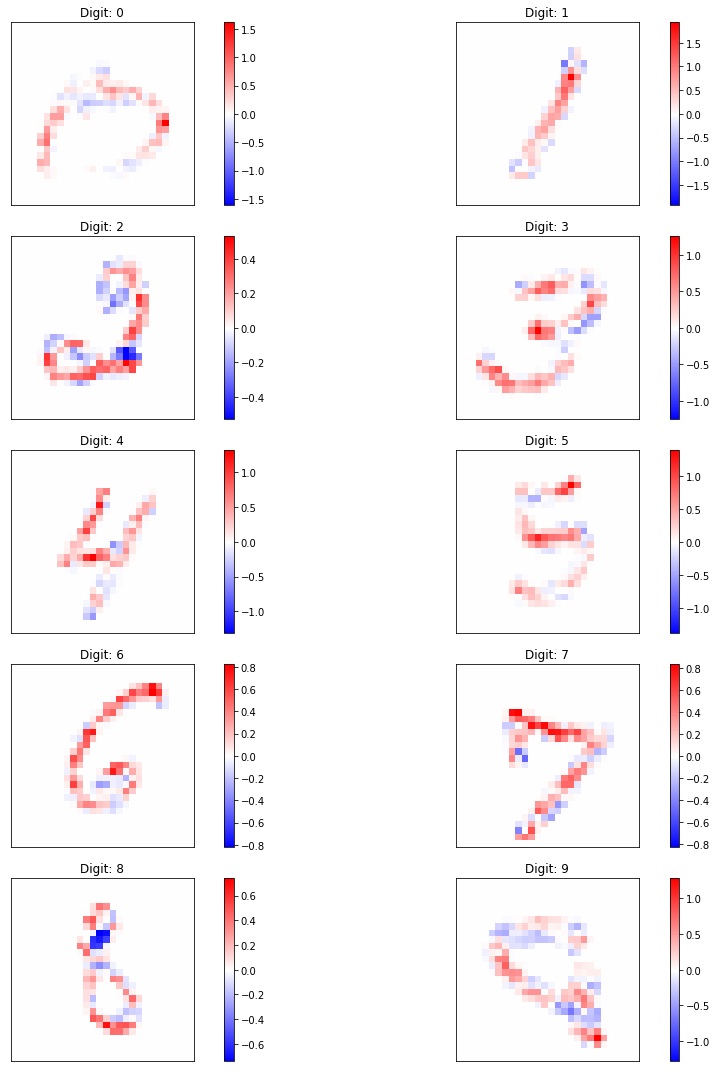

In [13]:
sample_imgs = [images[np.argmax(labels, axis=1) == i][5] for i in range(10)]
ref_img = np.zeros([1, 784])

res = []
for i in range(10):
    res.append(sess.run(C[-1], feed_dict={X: sample_imgs[i].reshape(1,784), X_ref: ref_img, training: False, ind: i}))


plt.figure(figsize=(15,15))
for i in range(5):
    plt.subplot(5, 2, 2 * i + 1)
    vmin, vmax = pixel_range(res[2 * i])
    plt.imshow(np.reshape(res[2 * i], [28, 28]), vmin=vmin, vmax=vmax, cmap='bwr')
    plt.title('Digit: {}'.format(2 * i))
    plt.xticks([])
    plt.yticks([])
    plt.colorbar()
    
    plt.subplot(5, 2, 2 * i + 2)
    vmin, vmax = pixel_range(res[2 * i + 1])
    plt.imshow(np.reshape(res[2 * i + 1], [28, 28]), vmin=vmin, vmax=vmax, cmap='bwr')
    plt.title('Digit: {}'.format(2 * i + 1))
    plt.xticks([])
    plt.yticks([])
    plt.colorbar()

plt.tight_layout()